In [1]:
import numpy as np
import matplotlib.pyplot as plt
import AtmosphericBlocking
import h5py
import sys, glob
%matplotlib inline

In [2]:
alpha=0.55
tau = 10*86400.0

In [3]:
def gaussforce(x,t,peak=2,inject=True):
    tc = 277.8
    tw = 2.5
    t = t/86400.0
    xc = 16800.0e3
    xw = 2800.0e3
    sx = 1.852e-5 + np.zeros(len(x))
    if inject:
        sx *= (1+peak*np.exp(-((x-xc)/xw)**2 - ((t-tc)/tw)**2))
    return sx

In [4]:
def noforce(x,t,peak=None,inject=None):
    sx = np.zeros(len(x))
    return sx

In [5]:
def xtsinforce(x,t,peak=None,inject=None):
    sx = 2.0e-5 + 2.0e-5*np.sin(2*np.pi*x/x[-1]-np.pi/6.0)*np.sin(2*np.pi*t/(4.0*86400.0))
    return sx

In [6]:
def xsinforce(x,t,peak=None,inject=None):
    sx = 2.0e-5 + 2.0e-5*np.sin(2*np.pi*x/x[-1]-np.pi/6.0)
    return sx

In [7]:
def noboru_cx(x,Lx,alpha):
    A0 = 10*(1-np.cos(4*np.pi*x/Lx))
    cx = 60 - 2*alpha*A0
    return cx,A0

In [8]:
model = AtmosphericBlocking.Model(nx=2048,Lx = 28000e3,dt=.001*86400,alpha=alpha,
                                        tmax=3.5*86400,D=3.26e5,tau=tau,
                                        sfunc=gaussforce,cfunc=noboru_cx,
                                        forcingpeak=2,injection=True,
                                        save_to_disk=True,
                                        overwrite=True,
                                        tsave_snapshots=200,
                                        path = 'output/')

## run the model

In [9]:
model.tmax = 320*86400
model.run()

## get output

### setup file

In [10]:
setup = h5py.File("output/setup.h5")
x = setup['grid/x'][:]

### merge snapshots

In [19]:
fnis = np.array(sorted(glob.glob("output/snapshots/*.h5")))

In [28]:
Ahat, F = 0,0
t = []
for fni in fnis[5000::2]:
    snap = h5py.File(fni)
    t.append(snap['t'][()])
    try:
        Ahat = np.vstack([Ahat, snap['A'][:]])
        F = np.vstack([F, snap['F'][:]])
    except:
        Ahat = snap['A'][:]
        F = snap['F'][:]

t = np.array(t)

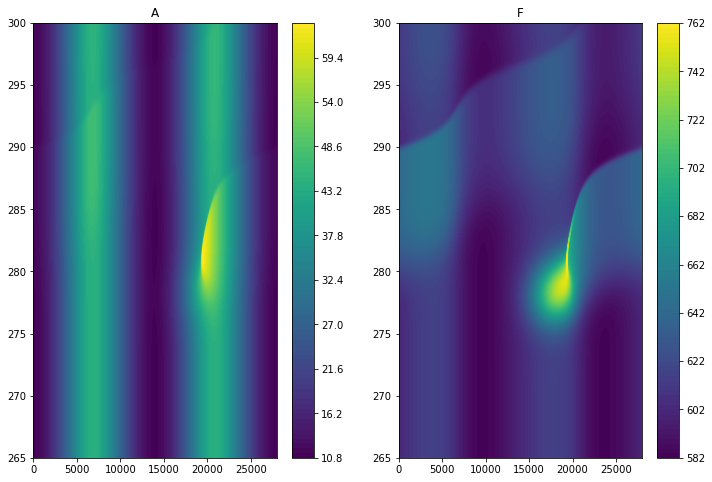

In [33]:
plt.figure(figsize=(12.,8))
plt.subplot(121)
plt.contourf(x/1e3,t/86400,Ahat+model.A0[np.newaxis,:],100,shading='Gouraud')
plt.ylim(265,300)
plt.colorbar()
plt.title("A")

plt.subplot(122)
plt.contourf(x/1e3,t/86400,F,100,shading='Gouraud')
plt.ylim(265,300)
plt.colorbar()
plt.title("F")